In [1]:
import os
import openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from openpyxl.utils import get_column_letter
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchinfo import summary
import torch.nn.functional as F

In [ ]:
ruta_carpeta = "/Users/Usuario/OneDrive/Escritorio/tfg/probeta 1/"
num_ensayos=11
nombres_archivos = [f"ENSAYO_{i}.xlsx" for i in range(num_ensayos)]

# Intervalo de frecuencias de cada canal
intervalo_canales = [
    (4, 804),      
    (810, 1610),   
    (1616, 2416),
    (2422, 3222),
    #(3228, 4028), Nos saltamos el sensor 5
    (4034, 4834),
    (4840, 5640),
    (5646, 6446),
    (6452, 7252),
    (7258, 8058)
]
# Definir las columnas de frecuencia, parte real y parte imaginaria para cada rango
frecuencia_col = [1, 4, 7, 10, 13, 16, 19, 22, 25]  # A, D, J
real_col = [2, 5, 8, 11, 14, 17, 20, 23, 26]  # B, E, K
imagin_col = [3, 6, 9, 12, 15, 18, 21, 24, 27]  # C, F, L
# Convertimos estas a letras para el print
frecuencia_col_letras = [get_column_letter(col) for col in frecuencia_col]
real_col_letras = [get_column_letter(col) for col in real_col]
imagin_col_letras = [get_column_letter(col) for col in imagin_col]

In [ ]:
# Obtenemos las partes reales e imagin separadas por ensayo, hojas, canales y rangos
data_frecuencias = []
data_partes_reales = []
data_partes_imagin = []
for ensayo_idx, nombre_archivo in enumerate(nombres_archivos):
    ruta_archivo = os.path.join(ruta_carpeta, nombre_archivo)
    wb = openpyxl.load_workbook(ruta_archivo)

    sweep1=wb['Sweep_1']
    sweep2=wb['Sweep_2']
    sweep3=wb['Sweep_3']
    
    sweeps = [sweep1, sweep2, sweep3]
    
    if ensayo_idx == 0:  # Solo se almacena una vez porque las frecuencias no cambian entre ensayos
        for col in frecuencia_col:
            column_data = [sweeps[0].cell(row=i, column=col).value for i in range(4, 805)]
            data_frecuencias.append(column_data)

    ensayo_partes_reales = []
    ensayo_partes_imagin = []
    
    for sheet in sweeps:
        sweep_data_reales = []
        sweep_data_imagin = []
        for inicio, fin in intervalo_canales:
            canal_data_reales = []
            canal_data_imagin = []
            for col_r, col_i in zip(real_col, imagin_col):
                column_data_reales = [sheet.cell(row=i, column=col_r).value for i in range(inicio, fin + 1)]
                column_data_imagin = [sheet.cell(row=i, column=col_i).value for i in range(inicio, fin + 1)]
                canal_data_reales.append(column_data_reales)
                canal_data_imagin.append(column_data_imagin)
            sweep_data_reales.append(canal_data_reales)
            sweep_data_imagin.append(canal_data_imagin)
        ensayo_partes_reales.append(sweep_data_reales)
        ensayo_partes_imagin.append(sweep_data_imagin)
    data_partes_reales.append(ensayo_partes_reales)
    data_partes_imagin.append(ensayo_partes_imagin)

In [ ]:
# Ahora, imprimir las partes reales y las imaginarias para comprobar la estructura
# print("\nPartes Reales y Partes Imaginarias:")

# Recorremos los datos de partes reales e imaginarias
# for ensayo_idx, (sweep_reales, sweep_imagin) in enumerate(zip(data_partes_reales, data_partes_imagin), start=1):
#     print(f"\nEnsayo {ensayo_idx-1}:")
#     for sweep_idx, (sweep_data_reales, sweep_data_imagin) in enumerate(zip(sweep_reales, sweep_imagin), start=1):
#         print(f"  Barrido {sweep_idx}:")
        
#         for canal_idx, (canal_reales, canal_imagin) in enumerate(zip(sweep_data_reales, sweep_data_imagin), start=1):
#             print(f"    Canal {canal_idx}:")
#             for col_idx, (column_reales, column_imagin) in enumerate(zip(canal_reales, canal_imagin), start=1):
#                 print(f"      Columna {real_col_letras[col_idx-1]}:")
#                 print(f"        Parte Real (primeros 5 valores): {column_reales[:5]}")
#                 print(f"        Parte Imaginaria (primeros 5 valores): {column_imagin[:5]}")


In [ ]:
data_frecuencias_np = np.array(data_frecuencias)
data_partes_reales_np = np.array(data_partes_reales)
data_partes_imagin_np = np.array(data_partes_imagin)

In [ ]:
print(data_frecuencias_np.shape)
print(data_partes_reales_np.shape)
print(data_partes_imagin_np.shape)

In [ ]:
data_partes_reales_np_vis = data_partes_reales_np.reshape(data_partes_reales_np.shape[0], data_partes_reales_np.shape[1], data_partes_reales_np.shape[2], -1)
data_partes_imagin_np_vis = data_partes_imagin_np.reshape(data_partes_imagin_np.shape[0], data_partes_imagin_np.shape[1], data_partes_imagin_np.shape[2], -1)
data_frecuencias_np_vis = data_frecuencias_np.reshape(-1)
print( data_partes_reales_np_vis.shape)
print( data_partes_imagin_np_vis.shape)
print(data_frecuencias_np_vis.shape)

In [ ]:
#VISUALIZACIÓN DE SEÑALES: Subplots de las señales separados por sensor, carga y sensor-barrido
n_ensayos, n_barridos, n_sensores, n_puntos = (11, 3, 9, 7209)
colormap = plt.get_cmap("tab20")
# Parte real
for sensor in range(n_sensores):
    fig, axs = plt.subplots(n_barridos, 1, figsize=(12, 8), sharex=True) # Creamos una figura con n_barridos subplots (uno por cada barrido).
    if sensor<4:
        fig.suptitle(f"Parte Real para Sensor {sensor+1}", fontsize=16)
    else: fig.suptitle(f"Parte Real para Sensor {sensor+2}", fontsize=16)
    
    # Iteramos sobre cada barrido
    for barrido in range(n_barridos):
        ax = axs[barrido]  
        for ensayo in range(n_ensayos):
            color = colormap(ensayo % 20)
            ax.plot(data_frecuencias_np_vis,data_partes_reales_np_vis[ensayo, barrido, sensor], label=f"Ensayo {ensayo+1}", color=color)
        
        ax.set_ylabel(f"Barrido {barrido+1}")
        ax.legend(fontsize=8, loc="upper right")
    
    axs[-1].set_xlabel("Frecuencia [Hz]")
    plt.tight_layout()
    plt.show()

In [ ]:
# #Parte imaginaria
# for sensor in range(n_sensores):
#     fig, axs = plt.subplots(n_barridos, 1, figsize=(12, 8), sharex=True) # Creamos una figura con n_barridos subplots (uno por cada barrido).
#     if sensor<4:
#         fig.suptitle(f"Parte Imaginaria para Sensor {sensor+1}", fontsize=16)
#     else: fig.suptitle(f"Parte Imaginaria para Sensor {sensor+2}", fontsize=16)
    
#     # Iteramos sobre cada barrido
#     for barrido in range(n_barridos):
#         ax = axs[barrido]  
#         for ensayo in range(n_ensayos):
#             color = colormap(ensayo % 20)
#             ax.plot(data_frecuencias_np_reshaped,data_partes_imagin_np_reshaped[ensayo, barrido, sensor, :], label=f"Ensayo {ensayo+1}",color=color)
        
#         ax.set_ylabel(f"Barrido {barrido+1}")
#         ax.legend(fontsize=8, loc="upper right")
    
#     axs[-1].set_xlabel("Frecuencia [Hz]")
#     plt.tight_layout()
#     plt.show()

In [ ]:
# # Debido a lo visto en la visualización de los datos, descartamos las señales obtenidas por el ensayo 11 en general y las del ensayo 9 en el caso del sensor 4.
# # Esta útima se elimina más adelante antes de entrenar nuestro VAE ya que ahora no se puede por incompatibilidad en el array numpy. Sin embargo nos deshacemos de ella ya en la visualización.
# data_partes_reales_npf=np.delete(data_partes_reales_np, 10, axis=0)
# print(data_partes_reales_npf.shape)
# data_partes_imagin_npf=np.delete(data_partes_imagin_np, 10, axis=0)
# print(data_partes_imagin_npf.shape)

In [ ]:
# data_partes_reales_npf_vis = data_partes_reales_npf.reshape(data_partes_reales_npf.shape[0], data_partes_reales_npf.shape[1], data_partes_reales_npf.shape[2], -1)
# print(data_partes_reales_npf_vis.shape)

In [ ]:
# VISUALIZACIÓN COMPARATIVA
# ---------------------------
n_ensayos_orig, n_barridos, n_sensores, n_puntos = (11, 3, 9, 7209)
n_ensayos_edit = 10
colormap = plt.get_cmap("tab20")

for sensor in range(n_sensores):
    
    fig, axs = plt.subplots(n_barridos, 2, figsize=(16, 8), sharex=True, sharey=True)  
    # 2 columnas: izquierda original, derecha editada

    if sensor < 4:
        fig.suptitle(f"Comparación Parte Real - Sensor {sensor+1}", fontsize=16)
    else:
        fig.suptitle(f"Comparación Parte Real - Sensor {sensor+2}", fontsize=16)

    for barrido in range(n_barridos):
        # --- Columna izquierda: señales originales ---
        ax_left = axs[barrido, 0]
        for ensayo in range(n_ensayos_orig):
            color = colormap(ensayo % 20)
            ax_left.plot(data_frecuencias_np_vis, 
                         data_partes_reales_np_vis[ensayo, barrido, sensor], 
                         label=f"Ensayo {ensayo+1}", color=color)
        ax_left.set_ylabel(f"Barrido {barrido+1}")
        if barrido == 0:
            ax_left.set_title("Original")

        # --- Columna derecha: señales editadas ---
        ax_right = axs[barrido, 1]
        for ensayo in range(n_ensayos_edit):
            if ensayo == 10:  # saltar ensayo 10
                continue
            if ensayo == 8 and sensor == 3:  # saltar sensor 4 en ensayo 9
                continue
            color = colormap(ensayo % 20)
            ax_right.plot(data_frecuencias_np_vis, 
                          data_partes_reales_np_vis[ensayo, barrido, sensor], 
                          label=f"Ensayo {ensayo+1}", color=color)
        if barrido == 0:
            ax_right.set_title("Filtrado para entrenamiento")

    axs[-1, 0].set_xlabel("Frecuencia [Hz]")
    axs[-1, 1].set_xlabel("Frecuencia [Hz]")

    plt.tight_layout()
    plt.show()


In [ ]:
data_partes_reales_np = data_partes_reales_np.reshape(11,3,9,81,-1)
data_partes_imagin_np = data_partes_imagin_np.reshape(11,3,9,81,-1)

In [ ]:
data_partes_reales_tensor = torch.tensor(data_partes_reales_np, dtype=torch.float32)
data_partes_imagin_tensor = torch.tensor(data_partes_imagin_np, dtype=torch.float32)
freqs_tensor = torch.tensor(data_frecuencias_np_vis, dtype=torch.float32)
torch.save(data_partes_reales_tensor, 'tensor_emis_real_corto.pt')
torch.save(data_partes_imagin_tensor, 'tensor_emis_imagin_corto.pt')
torch.save(freqs_tensor, 'freqs_emis_corto.pt')

In [82]:
data_partes_reales_tensor=torch.load('tensor_emis_real_corto.pt')
data_partes_imagin_tensor=torch.load('tensor_emis_imagin_corto.pt')
freqs_tensor=torch.load('freqs_emis_corto.pt')
print(data_partes_reales_tensor.shape)
print(data_partes_imagin_tensor.shape)
print(freqs_tensor.shape)

torch.Size([11, 3, 9, 81, 89])
torch.Size([11, 3, 9, 81, 89])
torch.Size([7209])


In [83]:
# # Nos quedamos solo con el primer ensayo (baseline)
# baseline = data_partes_reales_tensor[0]            # shape (3,9,1,7209)

# # Reorganizamos a (batch=1, channels=27, length=7209) para Conv1d
# x = baseline.reshape(1, 1, 7209).float()       # -> (1,27,7209)

# # (Opcional) Normalización simple a [-1,1] o z-score; aquí min-max por sencillez
# # Evita dividir por cero con clamp
# x_min = x.amin(dim=(1,2), keepdim=True)
# x_max = x.amax(dim=(1,2), keepdim=True)
# x = (x - x_min) / (x_max - x_min).clamp(min=1e-8)
# x = x * 2 - 1

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# x = x.to(device)

# # --------- 2) Autoencoder mínimo ----------
# # Encoder/decoder diminutos con Conv1d (kernel=3, padding=1 para mantener longitud)
# class TinyAE(nn.Module):
#     def __init__(self, in_ch=1, bottleneck_ch=4):
#         super().__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv1d(in_ch, 8, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv1d(8, bottleneck_ch, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#         )
#         self.decoder = nn.Sequential(
#             nn.Conv1d(bottleneck_ch, 8, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv1d(8, in_ch, kernel_size=3, padding=1),
#             # sin activación final (regresión)
#         )

#     def forward(self, x):
#         z = self.encoder(x)
#         out = self.decoder(z)
#         return out

# model = TinyAE(in_ch=1, bottleneck_ch=4).to(device)

# # --------- 3) Pérdida y optimizador ----------
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-3)

# # --------- 4) Entrenamiento ----------
# epochs = 200  # ajusta a gusto
# loss_history = []

# model.train()
# for epoch in range(1, epochs+1):
#     optimizer.zero_grad()
#     recon = model(x)          # reconstrucción del propio input
#     loss = criterion(recon, x)
#     loss.backward()
#     optimizer.step()

#     loss_history.append(loss.item())
#     if epoch % 10 == 0 or epoch == 1:
#         print(f"Epoch {epoch:3d}/{epochs} - Loss: {loss.item():.6f}")

# # --------- 5) Visualización de la pérdida por épocas ----------
# plt.figure()
# plt.plot(range(1, epochs+1), loss_history, marker='o', linewidth=1)
# plt.xlabel('Época')
# plt.ylabel('MSE (pérdida)')
# plt.title('Evolución de la pérdida (baseline = ensayo 1)')
# plt.grid(True)
# plt.show()

In [84]:
# # ============================================
# # Autoencoders por (ensayo, sensor) + Barplots
# # ============================================
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import matplotlib.pyplot as plt
# import numpy as np
# import math
# import random

# # ---------------------------
# # 0) Reproducibilidad
# # ---------------------------
# SEED = 42
# random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# # ---------------------------
# # 1) Datos: (E, B, S, C, L)
# # ---------------------------
# assert isinstance(data_partes_reales_tensor, torch.Tensor), "Debe ser torch.Tensor"
# assert data_partes_reales_tensor.ndim == 5, "Esperaba shape (E,B,S,C,L)"

# E, B, S, C, L = data_partes_reales_tensor.shape
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # ---------------------------
# # 2) Modelo: Autoencoder 1D mini
# # ---------------------------
# class TinyAE1D(nn.Module):
#     def __init__(self, in_ch=1, bottleneck_ch=4):
#         super().__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv1d(in_ch, 8, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv1d(8, bottleneck_ch, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#         )
#         self.decoder = nn.Sequential(
#             nn.Conv1d(bottleneck_ch, 8, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv1d(8, in_ch, kernel_size=3, padding=1),
#         )

#     def forward(self, x):
#         z = self.encoder(x)
#         return self.decoder(z)

# # ---------------------------
# # 3) Utilidades
# # ---------------------------
# def zscore_per_channel(x):
#     """
#     x: (B, C, L)  -> normaliza por canal usando media y std
#     """
#     mean = x.mean(dim=(0, 2), keepdim=True)
#     std = x.std(dim=(0, 2), keepdim=True).clamp(min=1e-6)
#     return (x - mean) / std

# def train_autoencoder(x, epochs=60, lr=1e-3, bottleneck=4, verbose=False):
#     """
#     x: (B, C, L) tensor en device, ya normalizado
#     Devuelve: pérdida final (float), y opcionalmente historial si se quisiera
#     """
#     model = TinyAE1D(in_ch=x.shape[1], bottleneck_ch=bottleneck).to(device)
#     opt = optim.Adam(model.parameters(), lr=lr)
#     crit = nn.MSELoss()

#     model.train()
#     loss_val = None
#     for ep in range(1, epochs + 1):
#         opt.zero_grad()
#         recon = model(x)                  # (B, C, L)
#         loss = crit(recon, x)
#         loss.backward()
#         opt.step()
#         loss_val = float(loss.item())
#         if verbose and (ep == 1 or ep % 10 == 0):
#             print(f"Epoch {ep:03d}/{epochs} - loss {loss_val:.6f}")
#     return loss_val

# # ---------------------------
# # 4) Entrenamiento por (ensayo, sensor)
# #     y acumulación de pérdidas finales
# # ---------------------------
# epochs =  300        # puedes ajustar
# lr = 1e-3
# bottleneck = 2

# loss_matrix = np.zeros((S, E), dtype=np.float64)  # filas=sensores, cols=ensayos

# with torch.no_grad():
#     pass  # solo para dejar claro el ámbito, entrenaremos con grad

# for s_idx in range(S):
#     for e_idx in range(E):
#         # x_es: (B, C, L)   -> extrae barridos del sensor s en el ensayo e
#         x_es = data_partes_reales_tensor[e_idx, :, s_idx, :, :]  # (B, C, L)
#         # Asegura float y al device
#         x_es = x_es.float().to(device)
#         # Normalización por canal (recomendado)
#         x_es = zscore_per_channel(x_es)

#         # Entrenar AE pequeño
#         loss_final = train_autoencoder(
#             x_es, epochs=epochs, lr=lr, bottleneck=bottleneck, verbose=False
#         )
#         loss_matrix[s_idx, e_idx] = loss_final

# # ---------------------------
# # 5) "Cuadro de Barplots"
# #     - Fila = sensor
# #     - x = ensayos
# #     - y = pérdida final por (ensayo, sensor)
# # ---------------------------
# num_rows = S
# fig, axes = plt.subplots(
#     nrows=num_rows, ncols=1, figsize=(10, max(2.0, 1.5 * num_rows)), sharex=True
# )

# if S == 1:
#     axes = [axes]  # asegurar iterable

# ensayo_labels = [f"E{e+1}" for e in range(E)]

# for s_idx, ax in enumerate(axes):
#     ax.bar(range(E), loss_matrix[s_idx, :])
#     ax.set_ylabel("Loss")
#     ax.set_title(f"Sensor {s_idx+1}")
#     ax.grid(True, axis='y', linestyle='--', alpha=0.4)
#     ax.set_xticks(range(E))
#     ax.set_xticklabels(ensayo_labels, rotation=0)

# axes[-1].set_xlabel("Ensayo")
# fig.suptitle("Cuadro de Barplots: Pérdida final por (Ensayo) para cada Sensor", y=1.02, fontsize=12)
# plt.tight_layout()
# plt.show()

# # (Opcional) inspeccionar/guardar la matriz de pérdidas
# print("Matriz pérdidas [sensor, ensayo]:\n", loss_matrix)


In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        
        # Encoder (idéntico)
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, 3, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 32, 3, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 64, 3, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 64, 3, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 128, 3, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(128, 128, 3, stride=2, padding=2),
            nn.ReLU()
        )
        
        # Obtener tamaño de salida del encoder dinámicamente (para L=89)
        with torch.no_grad():
            sample_input = torch.randn(1, 1, 7209)
            enc_out = self.encoder(sample_input)          # [1, 128, L_enc]
            self.encoded_dim = enc_out.numel() // enc_out.shape[0]  # 128 * L_enc
            self.enc_C = enc_out.shape[1]                 # 128
            self.enc_L = enc_out.shape[2]                 # L_enc dinámico
        
        # Proyecciones al latente y vuelta (sin mu/logvar)
        self.fc_enc = nn.Linear(self.encoded_dim, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, self.encoded_dim)

        # Decoder (idéntico)
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(128, 128, 3, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 64, 3, stride=2, padding=2, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 64, 3, stride=2, padding=2, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 32, 3, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 32, 3, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 1, 3, stride=2, padding=2),
            nn.Sigmoid()   # déjalo si trabajas en [0,1]; quítalo si no normalizas a ese rango
        )

    def forward(self, x):
        # x: [B, 1, 89]
        h = self.encoder(x)                 # [B, 128, L_enc]
        h_flat = h.view(h.size(0), -1)      # [B, 128*L_enc]
        z = self.fc_enc(h_flat)             # [B, latent_dim]
        h_dec = self.fc_dec(z)              # [B, 128*L_enc]
        h_dec = h_dec.view(x.size(0), self.enc_C, self.enc_L)  # [B, 128, L_enc]
        x_hat = self.decoder(h_dec)         # [B, 1, 89] (por la cadena de deconvs que ya tenías)
        return x_hat, z


In [86]:
latent_dim=2
model = Autoencoder(latent_dim)
summary(model, input_size=(64, 1, 7209))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [64, 1, 7209]             --
├─Sequential: 1-1                        [64, 128, 115]            --
│    └─Conv1d: 2-1                       [64, 32, 3606]            128
│    └─ReLU: 2-2                         [64, 32, 3606]            --
│    └─Conv1d: 2-3                       [64, 32, 1804]            3,104
│    └─ReLU: 2-4                         [64, 32, 1804]            --
│    └─Conv1d: 2-5                       [64, 64, 903]             6,208
│    └─ReLU: 2-6                         [64, 64, 903]             --
│    └─Conv1d: 2-7                       [64, 64, 453]             12,352
│    └─ReLU: 2-8                         [64, 64, 453]             --
│    └─Conv1d: 2-9                       [64, 128, 228]            24,704
│    └─ReLU: 2-10                        [64, 128, 228]            --
│    └─Conv1d: 2-11                      [64, 128, 115]            49,

In [87]:
learning_rate = 1e-3 # Determina qué tan grandes son los ajustes en los parámetros del modelo después de cada lote o época.
batch_size = 64 # Es la cantidad de datos que se pasan por la red antes de actualizar los parámetros
epochs = 150 # Una época es una pasada completa por todo el dataset de entrenamiento
# def loss_fn(outputs, inputs, mu, logvar, beta=0.05):
#     mse = (outputs - inputs) ** 2  # Calcula el error cuadrático

#     # Reducción lotes/muestras con mean
#     loss_0= torch.mean(mse, dim=0)
    
#     # Reducción secuencia/longitud con sum
#     loss_2 = torch.sum(mse, dim=2)
    
#     recon_loss = torch.sum(loss_2) + torch.sum(loss_0)
    
#     kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     total_loss= recon_loss + beta * kl_divergence
#     return total_loss, recon_loss, beta*kl_divergence
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)                          

In [88]:
def loss_fn(outputs, inputs):
    recon_loss = ((outputs - inputs)**2).sum()  # suma total, gran escala
    return recon_loss





In [89]:
baselineycarga=data_partes_reales_tensor[:1]
print(baselineycarga.shape)
loads=data_partes_reales_tensor[1:]
print(loads.shape)

torch.Size([1, 3, 9, 81, 89])
torch.Size([10, 3, 9, 81, 89])


In [90]:
def scale_signal(signal):
    # signal: tensor [num_channels, sequence_length] o [batch, L]
    min_val = signal.min(dim=-1, keepdim=True)[0]
    max_val = signal.max(dim=-1, keepdim=True)[0]
    scaled = (signal - min_val) / (max_val - min_val + 1e-8)
    return scaled

In [91]:
# Aprende min/max SOLO en baseline (antes del reshape a [N,1,89] está bien también)
baseline_min = baselineycarga.amin(dim=-1, keepdim=True)  # [B,1,1] o [B,1,89]? depende de forma
baseline_max = baselineycarga.amax(dim=-1, keepdim=True)

def scale_with(baseline_min, baseline_max, x):
    # Reescala usando estadísticas del baseline (broadcasting)
    return (x - baseline_min) / (baseline_max - baseline_min + 1e-8)

# Si quieres una sola min/max global del baseline:
global_min = baselineycarga.min()
global_max = baselineycarga.max()

def scale_global(x):
    return (x - global_min) / (global_max - global_min + 1e-8)


In [92]:
# Preparar los datos para DataLoader
# Reestructurar los tensores para que tengan la forma [num_samples, num_channels, sequence_length]
loads=loads.view(-1, 1, 7209)
baselineycarga=baselineycarga.view(-1, 1, 7209)
print(loads.shape)
print(baselineycarga.shape)

torch.Size([270, 1, 7209])
torch.Size([27, 1, 7209])


In [93]:
# # FILTRAR SEÑALES
# indices_a_eliminar = []
# num_ensayos=10

# for ensayo_local in range(num_ensayos):
#     for barrido in range(3):       # 3 barridos
#         for sensor in range(9):    # 9 sensores
#             for rango in range(81):  # 81 rangos
#                 if ensayo_local == 9: # 11 en general
#                     # Eliminar todo el último ensayo 11 (índice_local=9)
#                     idx = (((ensayo_local * 3 + barrido) * 9 + sensor) * 81 + rango)
#                     indices_a_eliminar.append(idx)
#                 elif ensayo_local == 7 and sensor == 3:
#                     # Eliminar ensayo 9 (índice_local=7) SOLO sensor 4 (índice_local=3)
#                     idx = (((ensayo_local * 3 + barrido) * 9 + sensor) * 81 + rango)
#                     indices_a_eliminar.append(idx)

# indices_a_eliminar = torch.tensor(indices_a_eliminar, dtype=torch.long)

# # Crear máscara y filtrar
# mask = torch.ones(loads.shape[0], dtype=torch.bool)
# mask[indices_a_eliminar] = False
# loads_filtrado = loads[mask]

# print("Shape loads original:", loads.shape)
# print("Shape loads filtrado:", loads_filtrado.shape)

In [94]:
baselineycarga_scaled = scale_global(baselineycarga)
loads_scaled = scale_global(loads)

# loads_filtrado_scaled = scale_signal(loads_filtrado)  # Loads que se utiliza para el entrenamiento
#Recomendación: usa scale_global para entrenamiento y evaluación
# baselineycarga_scaled = scale_global(baselineycarga)
# loads_scaled         = scale_global(loads)
# loads_filtrado_scaled= scale_global(loads_filtrado)

data_scaled = torch.cat([baselineycarga_scaled, loads_scaled], dim=0)
data_original = torch.cat([baselineycarga, loads], dim=0)

train_dataset = TensorDataset(baselineycarga)
# test_dataset = TensorDataset(loads_filtrado_scaled)     #?????

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Época 1/150, Pérdida: 83254816.000000
Época 2/150, Pérdida: 83229352.000000
Época 3/150, Pérdida: 83165696.000000
Época 4/150, Pérdida: 82991056.000000
Época 5/150, Pérdida: 82534848.000000
Época 6/150, Pérdida: 81647256.000000
Época 7/150, Pérdida: 80699328.000000
Época 8/150, Pérdida: 80282656.000000
Época 9/150, Pérdida: 80209232.000000
Época 10/150, Pérdida: 80198232.000000
Época 11/150, Pérdida: 80196984.000000
Época 12/150, Pérdida: 80196880.000000
Época 13/150, Pérdida: 80196880.000000
Época 14/150, Pérdida: 80196880.000000
Época 15/150, Pérdida: 80196880.000000
Época 16/150, Pérdida: 80196888.000000
Época 17/150, Pérdida: 80196880.000000
Época 18/150, Pérdida: 80196880.000000
Época 19/150, Pérdida: 80196880.000000
Época 20/150, Pérdida: 80196888.000000
Época 21/150, Pérdida: 80196880.000000
Época 22/150, Pérdida: 80196880.000000
Época 23/150, Pérdida: 80196880.000000
Época 24/150, Pérdida: 80196880.000000
Época 25/150, Pérdida: 80196888.000000
Época 26/150, Pérdida: 80196880.00

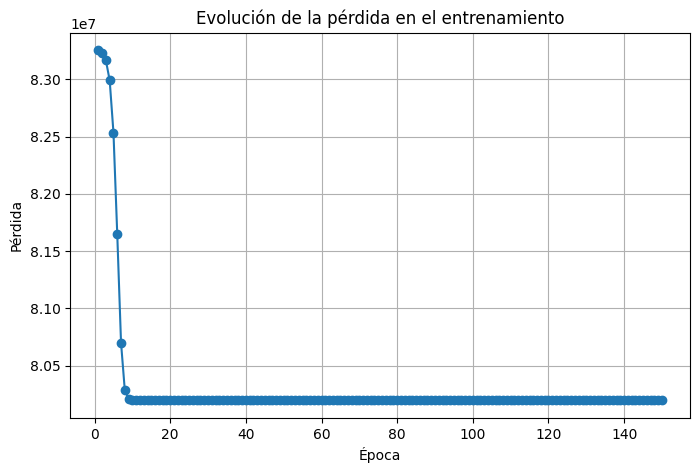

[83254816.0,
 83229352.0,
 83165696.0,
 82991056.0,
 82534848.0,
 81647256.0,
 80699328.0,
 80282656.0,
 80209232.0,
 80198232.0,
 80196984.0,
 80196880.0,
 80196880.0,
 80196880.0,
 80196880.0,
 80196888.0,
 80196880.0,
 80196880.0,
 80196880.0,
 80196888.0,
 80196880.0,
 80196880.0,
 80196880.0,
 80196880.0,
 80196888.0,
 80196880.0,
 80196888.0,
 80196880.0,
 80196896.0,
 80196888.0,
 80196880.0,
 80196880.0,
 80196896.0,
 80196888.0,
 80196880.0,
 80196888.0,
 80196888.0,
 80196880.0,
 80196880.0,
 80196888.0,
 80196880.0,
 80196880.0,
 80196880.0,
 80196880.0,
 80196880.0,
 80196880.0,
 80196888.0,
 80196888.0,
 80196896.0,
 80196888.0,
 80196880.0,
 80196880.0,
 80196896.0,
 80196880.0,
 80196880.0,
 80196888.0,
 80196880.0,
 80196880.0,
 80196880.0,
 80196888.0,
 80196888.0,
 80196880.0,
 80196880.0,
 80196880.0,
 80196880.0,
 80196880.0,
 80196880.0,
 80196880.0,
 80196880.0,
 80196880.0,
 80196880.0,
 80196888.0,
 80196888.0,
 80196880.0,
 80196888.0,
 80196880.0,
 80196880.0,

In [95]:
# Entrenamiento del modelo
def train_model(model, train_loader, optimizer, epochs):
    losses = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for batch in train_loader:
            inputs = batch[0]
    
            # ---- Forward ----
            outputs = model(inputs)
    
            # AE: devuelve (x_hat, z)
            # VAE: devuelve (x_hat, mu, logvar)
            if isinstance(outputs, tuple):
                if len(outputs) == 2:      # Autoencoder
                    x_hat, z = outputs
                    loss = loss_fn(x_hat, inputs)
                elif len(outputs) == 3:    # VAE
                    x_hat, mu, logvar = outputs
                    loss, _, _ = loss_fn(x_hat, inputs, mu, logvar)
                else:
                    raise ValueError("El modelo devolvió una tupla inesperada")
            else:
                # Caso raro: modelo devuelve solo la reconstrucción
                x_hat = outputs
                loss = loss_fn(x_hat, inputs)

        # ---- Backward ----
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Época {epoch+1}/{epochs}, Pérdida: {avg_loss:.6f}")

    # Guardar pesos al final
    ruta = f"vaePRUEBA_B.pth"
    torch.save(model.state_dict(), ruta)
    print(f"Modelo guardado en {ruta}")
     # ---- 📈 Graficar curva de pérdida ----
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs+1), losses, marker="o", linestyle="-")
    plt.xlabel("Época")
    plt.ylabel("Pérdida")
    plt.title("Evolución de la pérdida en el entrenamiento")
    plt.grid(True)
    plt.show()

    return losses

train_model(model, train_loader, optimizer, epochs)

In [97]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(f"vaePRUEBA_B.pth", map_location=device))

<All keys matched successfully>

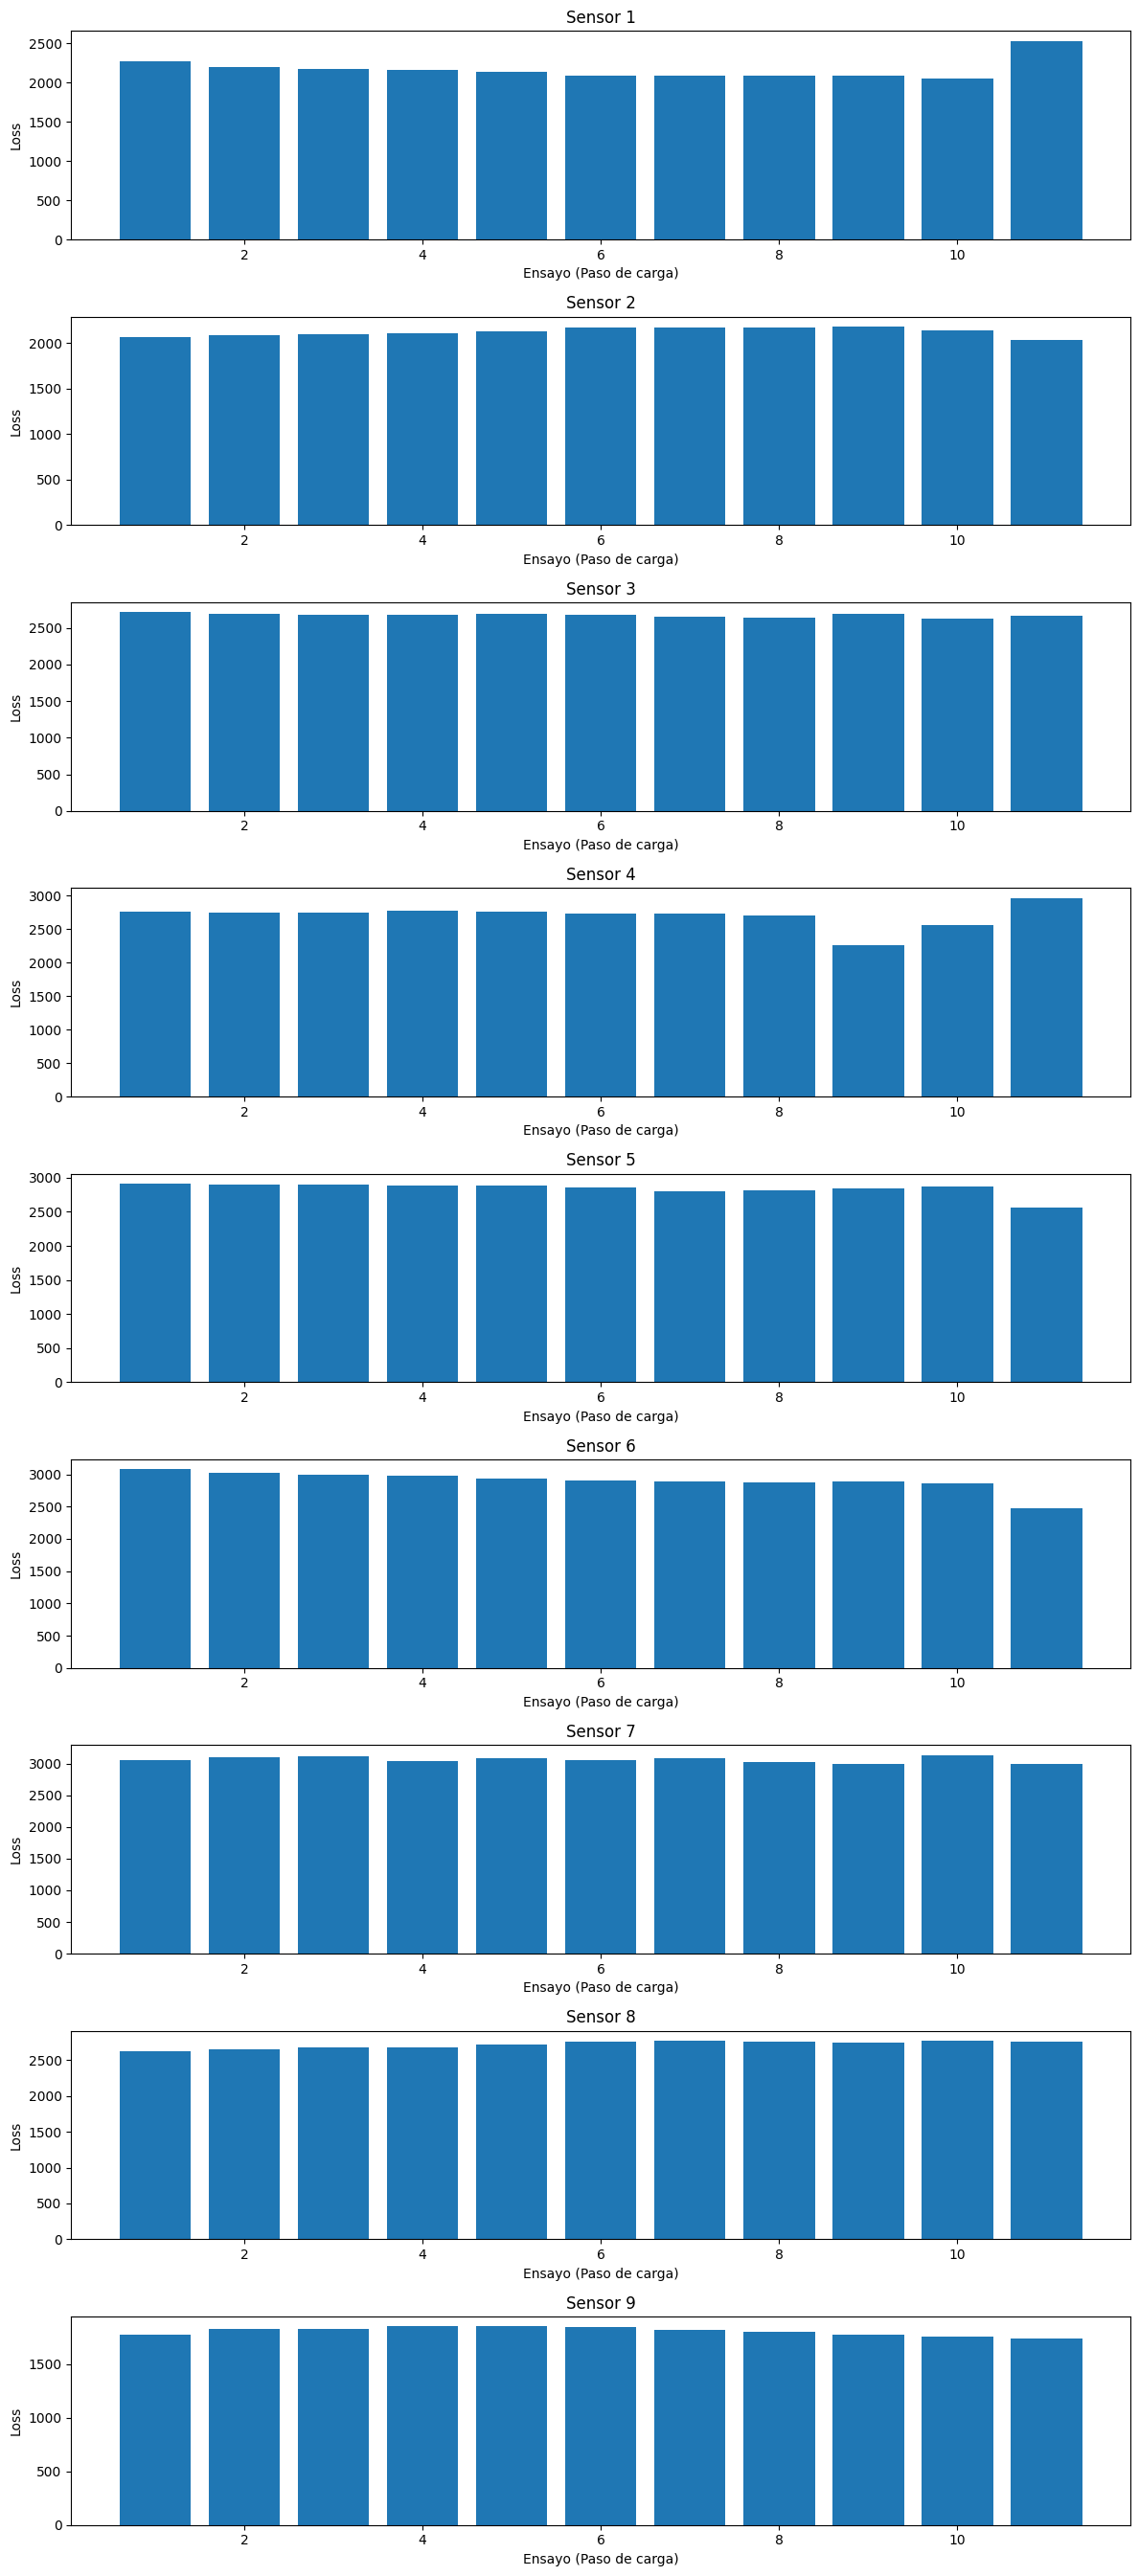

In [227]:
import torch.nn.functional as F

# --- Función para calcular la pérdida ---
def calcular_loss_por_sensor(model, datos):

    model.eval()
    num_ensayos, num_barridos, num_sensores, num_rangos, num_señales = datos.shape
    
    # Guardar resultados: dict[sensor][ensayo] = loss medio
    resultados = {s: [] for s in range(num_sensores)}
    
    with torch.no_grad():
        for ensayo in range(num_ensayos):
            # Selecciona datos de este ensayo -> shape [barridos, sensores, rangos, señales]
            datos_ensayo = datos[ensayo]  
            
            for sensor in range(num_sensores):
                # Selecciona datos de este sensor en el ensayo -> shape [barridos, rangos, señales]
                datos_sensor = datos_ensayo[:, sensor]  
                
                inputs = scale_signal(datos_sensor.reshape(-1, 1, 7209))         # (batch ,1 , 89)
                
                # Pasar por el modelo
                outputs, mu, logvar = model(inputs)
                
                # Calcular pérdida
                # loss = F.mse_loss(outputs, inputs, reduction="mean").item()
                loss, _, _ = loss_fn(outputs, inputs, mu, logvar)
                loss=loss.item()
                resultados[sensor].append(loss)
    
    return resultados


# --- Calcular pérdidas ---
loss_por_sensor = calcular_loss_por_sensor(model, data_partes_reales_tensor)

# --- Graficar ---
num_sensores = len(loss_por_sensor)
num_ensayos = len(next(iter(loss_por_sensor.values())))

fig, axes = plt.subplots(num_sensores, 1, figsize=(12, 3*num_sensores), sharex=False)

if num_sensores == 1:
    axes = [axes]

for sensor, ax in enumerate(axes):
    ax.bar(range(1, num_ensayos+1), loss_por_sensor[sensor])
    ax.set_title(f"Sensor {sensor+1}")
    ax.set_ylabel("Loss")
    ax.set_xlabel("Ensayo (Paso de carga)")

plt.tight_layout()
# plt.show()


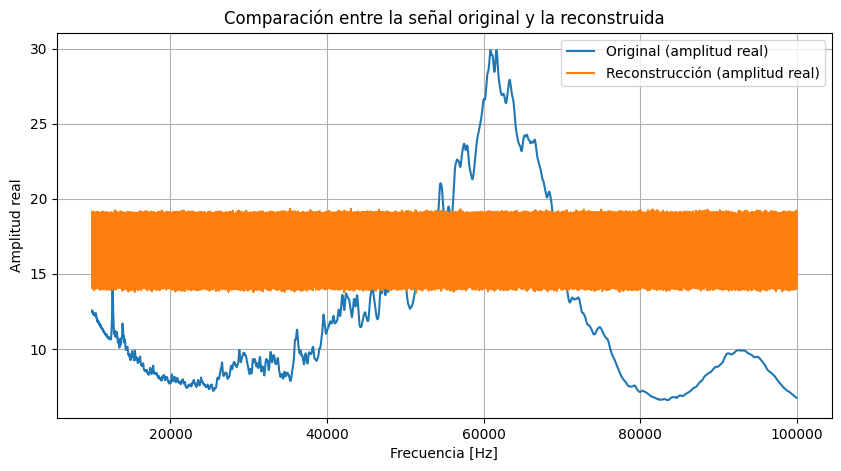

In [228]:
def evaluate_model(model, data_scaled, data_original, freqs_tensor):

    model.eval()
    with torch.no_grad():
        # Tomamos la primera señal (index 0)
        original_signal_scaled = data_scaled[0]       # [1, 89]
        original_signal_real = data_original[0]       # [1, 89]

        # Extraer las frecuencias correspondientes a esa señal
        freqs_signal = freqs_tensor[:original_signal_real.shape[-1]]  # primeros 89 valores

        # Reconstrucción
        reconstructed_scaled = model(original_signal_scaled.unsqueeze(0))[0].squeeze().detach()

        # Desnormalizar usando min y max de la señal real
        min_val = original_signal_real.min()
        max_val = original_signal_real.max()
        reconstructed_real = reconstructed_scaled * (max_val - min_val) + min_val

        # Graficar
        plt.figure(figsize=(10, 5))
        plt.plot(freqs_signal.numpy(), original_signal_real.squeeze().numpy(), label="Original (amplitud real)")
        plt.plot(freqs_signal.numpy(), reconstructed_real.numpy(), label="Reconstrucción (amplitud real)")
        plt.legend()
        plt.title("Comparación entre la señal original y la reconstruida")
        plt.xlabel("Frecuencia [Hz]")
        plt.ylabel("Amplitud real")
        plt.grid(True)
        plt.show()

# Ejemplo de uso
evaluate_model(model, data_scaled, data_original, freqs_tensor)



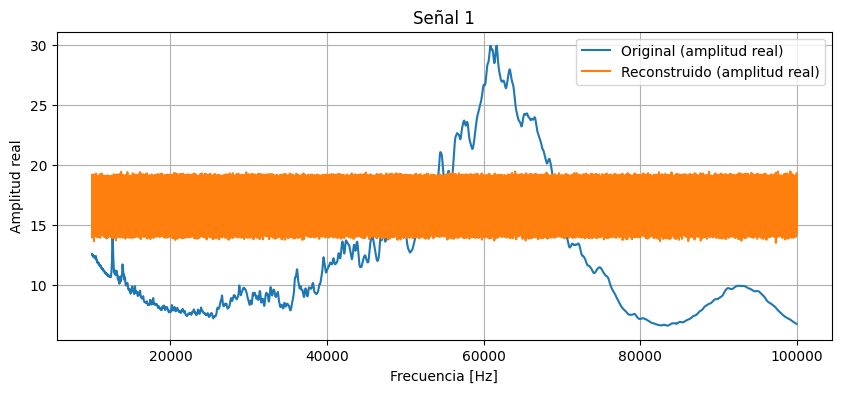

ValueError: x and y must have same first dimension, but have shapes (0,) and (7209,)

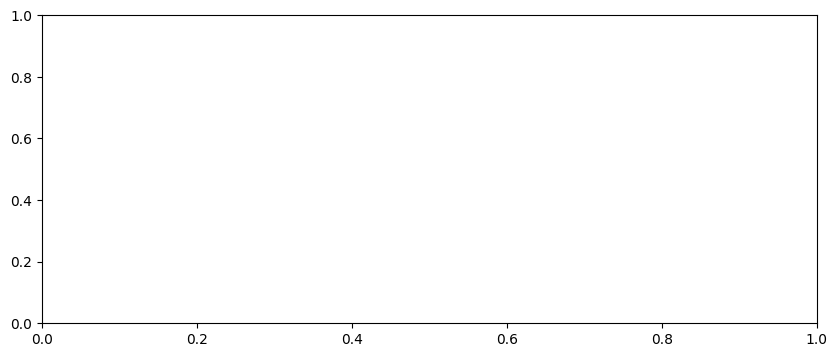

In [229]:
def evaluate_test_signals(model, data_scaled, data_original, freqs_tensor):
    model.eval()
    with torch.no_grad():
        for i, (scaled_signal, real_signal) in enumerate(zip(data_scaled[:8], data_original[:8])):
            # Índices para extraer el bloque de frecuencias de esta señal
            start_idx = i * real_signal.shape[-1]  # i * 89
            end_idx = start_idx + real_signal.shape[-1]
            freqs_signal = freqs_tensor[start_idx:end_idx]  # [89]

            # Paso por el modelo con la señal normalizada
            input_tensor = scaled_signal.unsqueeze(0)  # [1, 1, 89]
            reconstructed_scaled = model(input_tensor)[0].squeeze().detach()  # [89]

            # Des-normalización usando min y max de la señal real correspondiente
            min_val = real_signal.min()
            max_val = real_signal.max()
            reconstructed_real = reconstructed_scaled * (max_val - min_val) + min_val

            # Graficar
            plt.figure(figsize=(10, 4))
            plt.plot(freqs_signal, real_signal.squeeze().numpy(), label='Original (amplitud real)')
            plt.plot(freqs_signal, reconstructed_real.numpy(), label='Reconstruido (amplitud real)')
            plt.title(f"Señal {i+1}")
            plt.legend()
            plt.xlabel("Frecuencia [Hz]")
            plt.ylabel("Amplitud real")
            plt.grid(True)
            plt.show()

# Ejemplo de uso
evaluate_test_signals(model, data_scaled, data_original, freqs_tensor)



In [ ]:
def evaluate_single_signal(model, data_scaled, data_original, freqs_tensor,
                           ensayo_index=0, barrido_index=0, sensor_index=0):
    model.eval()
    with torch.no_grad():
        # ---- Calcular índices ----
        signal_idx = barrido_index * 9 + sensor_index  # 0..26 dentro del ensayo
        global_signal_index = ensayo_index * 27 + signal_idx  # posición global de la señal

        # Cada señal está formada por 81 bloques de 89 puntos
        start_block = global_signal_index * 81
        end_block = start_block + 81

        scaled_blocks = data_scaled[start_block:end_block]   # [81, 1, 89]
        real_blocks   = data_original[start_block:end_block] # [81, 1, 89]

        reconstructed_blocks = []
        original_blocks = []

        # ---- Pasar cada bloque por el modelo ----
        for scaled_signal, real_signal in zip(scaled_blocks, real_blocks):
            input_tensor = scaled_signal.unsqueeze(0)  # [1, 1, 89]
            reconstructed_scaled = model(input_tensor)[0].squeeze().detach()  # [89]

            # Desnormalizar con min/max del bloque real
            min_val = real_signal.min()
            max_val = real_signal.max()
            reconstructed_real = reconstructed_scaled * (max_val - min_val) + min_val

            reconstructed_blocks.append(reconstructed_real.cpu().numpy())
            original_blocks.append(real_signal.squeeze().cpu().numpy())

        # ---- Concatenar bloques → señal completa ----
        reconstructed_full = np.concatenate(reconstructed_blocks)
        original_full = np.concatenate(original_blocks)
        freqs_full = freqs_tensor[:original_full.shape[0]]

        # Ajustar etiqueta de sensor (saltando el 5)
        sensor_label = sensor_index + 1 if sensor_index < 4 else sensor_index + 2

        # ---- Graficar ----
        plt.figure(figsize=(12,5))
        plt.plot(freqs_full.numpy(), original_full, label="Original", alpha=0.7)
        plt.plot(freqs_full.numpy(), reconstructed_full, label="Reconstrucción", alpha=0.7)
        plt.title(f"Ensayo {ensayo_index} - Barrido {barrido_index+1} - Sensor {sensor_label}")
        plt.xlabel("Frecuencia")
        plt.ylabel("Amplitud")
        plt.grid(True)
        plt.legend()
        plt.show()


ValueError: x and y must have same first dimension, but have shapes (7209,) and (64881,)

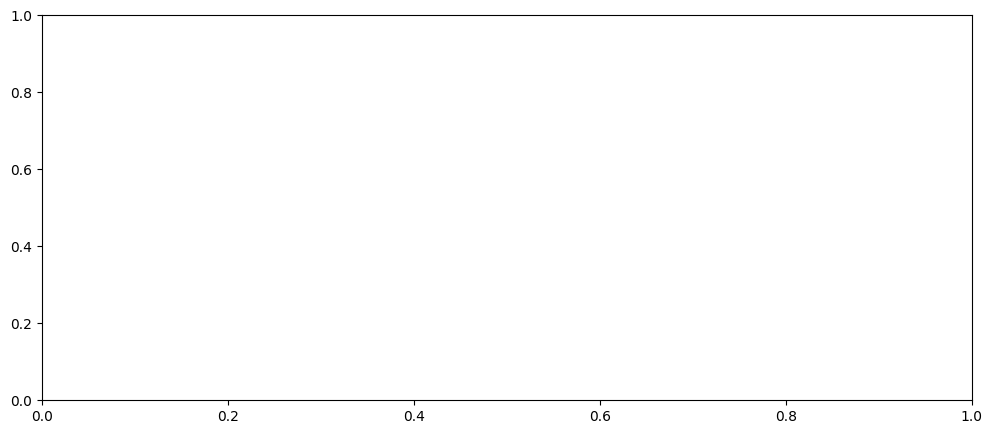

In [43]:
evaluate_single_signal(model, data_scaled, data_original, freqs_tensor,
                       ensayo_index=0, barrido_index=1, sensor_index=8)

evaluate_single_signal(model, data_scaled, data_original, freqs_tensor,
                       ensayo_index=10, barrido_index=1, sensor_index=5)


In [40]:
def evaluate_full_ensayo(model, data_scaled, data_original, freqs_tensor, ensayo_index=0):

    model.eval()
    with torch.no_grad():
        fig, axs = plt.subplots(9, 3, figsize=(15, 25), sharex=True)
        axs = axs.flatten()

        for signal_idx in range(27):  # 3 barridos × 9 sensores
            # Calcular barrido y sensor
            barrido = signal_idx // 9   # 0,1,2
            sensor = signal_idx % 9     # 0...8

            # Índice global de la señal dentro de data_scaled
            global_signal_index = ensayo_index * 27 + signal_idx

            # Rango de bloques
            start_block = global_signal_index * 81
            end_block = start_block + 81
            
            scaled_blocks = data_scaled[start_block:end_block]   # [81, 1, 89]
            real_blocks = data_original[start_block:end_block]   # [81, 1, 89]

            reconstructed_blocks = []
            original_blocks = []

            for scaled_signal, real_signal in zip(scaled_blocks, real_blocks):
                # Reconstrucción del bloque
                input_tensor = scaled_signal.unsqueeze(0)  # [1, 1, 89]
                reconstructed_scaled = model(input_tensor)[0].squeeze().detach()  # [89]

                # Desnormalización con min/max del bloque real
                min_val = real_signal.min()
                max_val = real_signal.max()
                reconstructed_real = reconstructed_scaled * (max_val - min_val) + min_val

                reconstructed_blocks.append(reconstructed_real.numpy())
                original_blocks.append(real_signal.squeeze().numpy())

            # Concatenar → señal completa (7209 puntos)
            reconstructed_full = np.concatenate(reconstructed_blocks)
            original_full = np.concatenate(original_blocks)
            freqs_full = freqs_tensor[:original_full.shape[0]]

            # Graficar en subplot correspondiente
            ax = axs[signal_idx]
            ax.plot(freqs_full.numpy(), original_full, label="Original", alpha=0.7)
            ax.plot(freqs_full.numpy(), reconstructed_full, label="Reconstrucción", alpha=0.7)

            # Etiqueta con sensor y barrido (saltando sensor 5)
            sensor_label = sensor + 1 if sensor < 4 else sensor + 2  
            ax.set_title(f"Barrido {barrido+1} - Sensor {sensor_label}", fontsize=9)
            ax.grid(True)


ValueError: need at least one array to concatenate

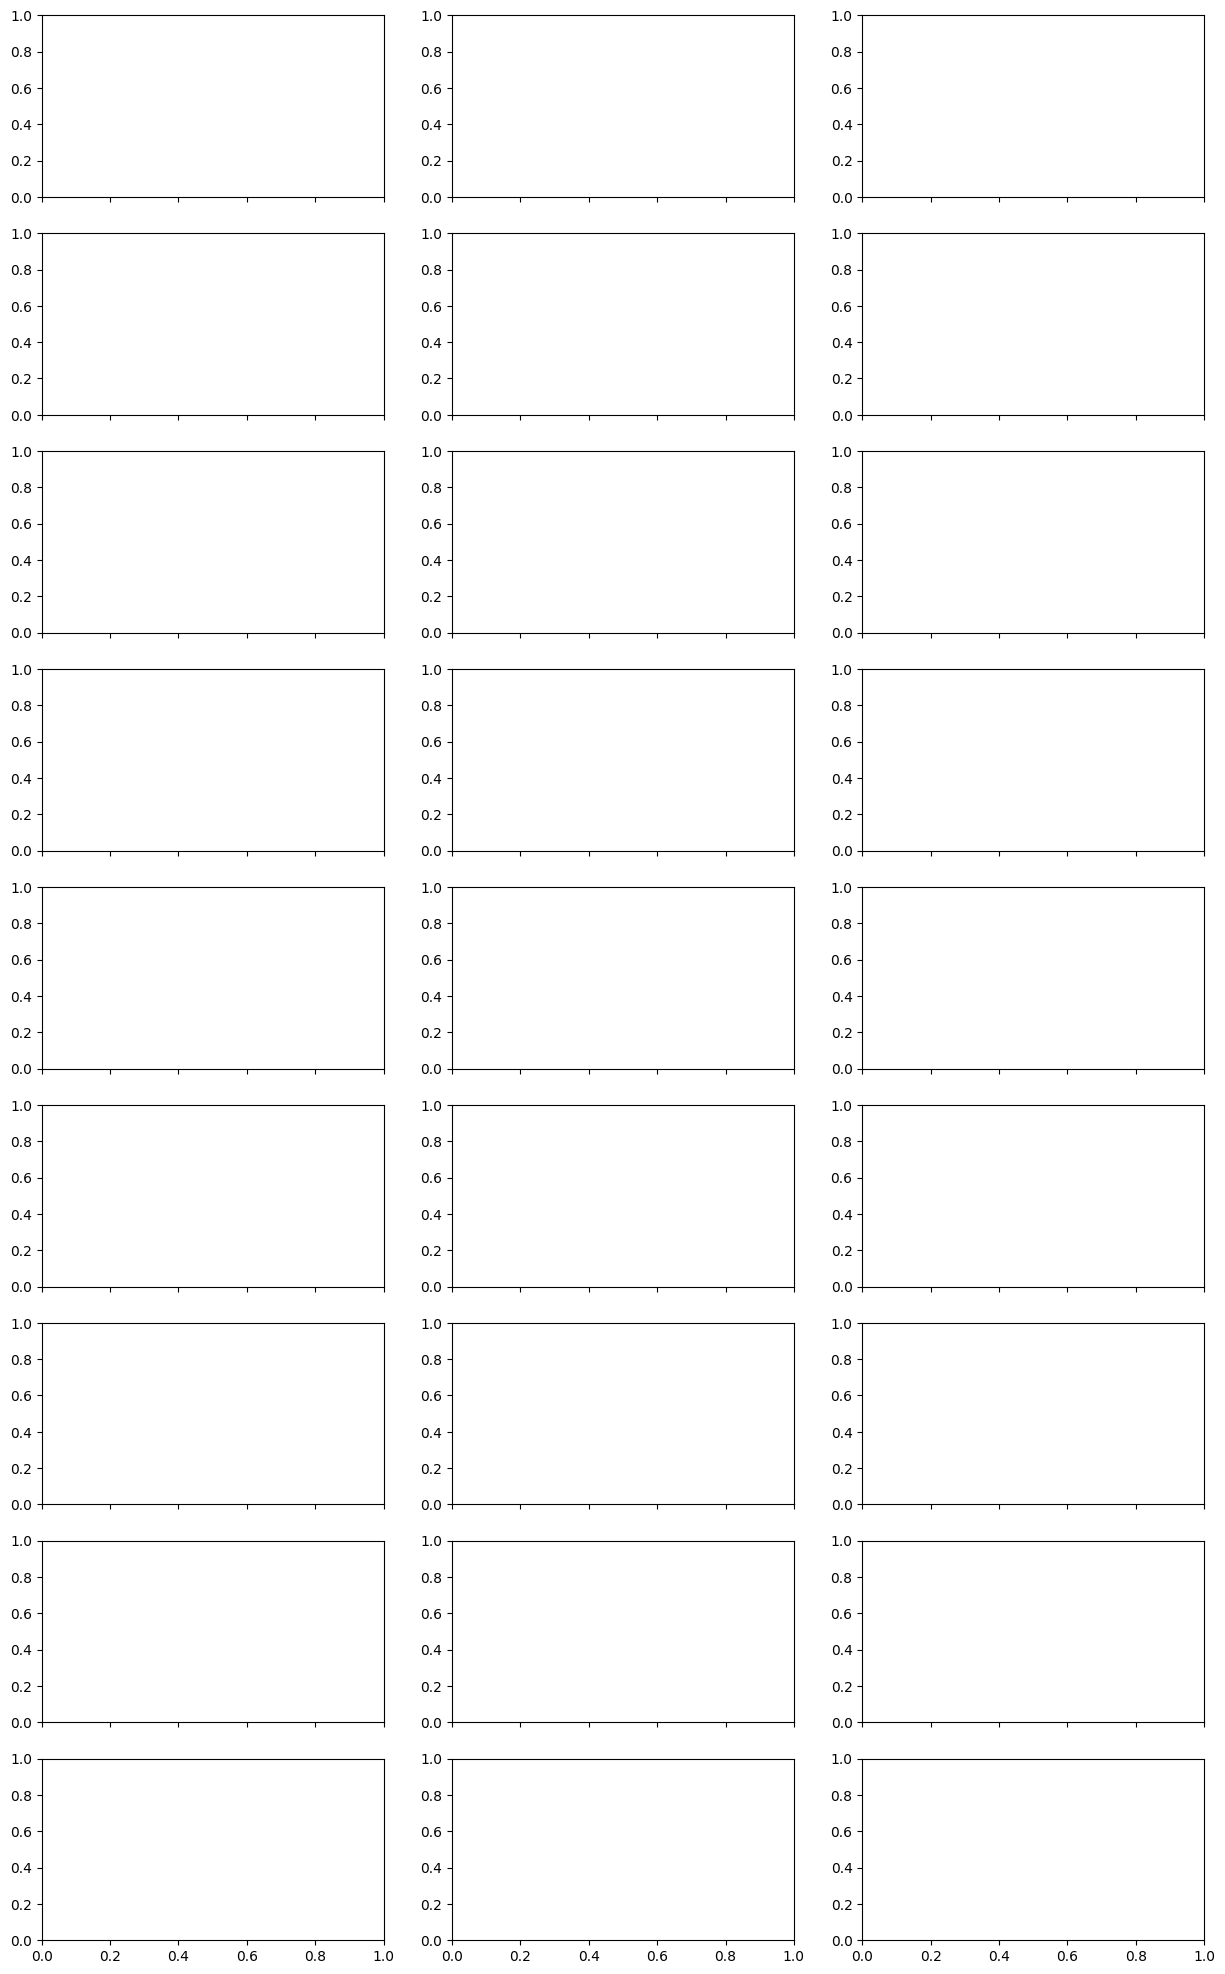

In [41]:
#Ejemplo: visualizar un ensayo de carga
evaluate_full_ensayo(model, data_scaled, data_original, freqs_tensor, ensayo_index=10)


In [ ]:
def evaluate_full_signal_with_blocks(model, data_scaled, data_original, freqs_tensor, ensayo_index=0, signal_idx=0):

    model.eval()
    with torch.no_grad():
        # Índice global de la señal dentro del dataset
        global_signal_index = ensayo_index * 27 + signal_idx

        # Rango de bloques de esta señal (81 bloques de 89 puntos)
        start_block = global_signal_index * 81
        end_block = start_block + 81

        scaled_blocks = data_scaled[start_block:end_block]   # [81, 1, 89]
        real_blocks = data_original[start_block:end_block]   # [81, 1, 89]

        reconstructed_blocks = []
        original_blocks = []

        for scaled_signal, real_signal in zip(scaled_blocks, real_blocks):
            input_tensor = scaled_signal.unsqueeze(0)  # [1, 1, 89]
            reconstructed_scaled = model(input_tensor)[0].squeeze().detach()  # [89]

            min_val = real_signal.min()
            max_val = real_signal.max()
            reconstructed_real = reconstructed_scaled * (max_val - min_val) + min_val

            reconstructed_blocks.append(reconstructed_real.numpy())
            original_blocks.append(real_signal.squeeze().numpy())

        # Señal completa
        reconstructed_full = np.concatenate(reconstructed_blocks)
        original_full = np.concatenate(original_blocks)
        freqs_full = freqs_tensor[:original_full.shape[0]].numpy()

        # Creamos la figura con 81 filas × 2 columnas
        fig, axs = plt.subplots(81, 2, figsize=(14, 240), sharex=False)
        
        for block_idx in range(81):
            freqs_block = freqs_full[block_idx*89:(block_idx+1)*89]
            original_block = original_blocks[block_idx]
            reconstructed_block = reconstructed_blocks[block_idx]

            # -------- Izquierda: bloque 89 pts --------
            ax_left = axs[block_idx, 0]
            ax_left.plot(freqs_block, original_block, label="Original", alpha=0.8)
            ax_left.plot(freqs_block, reconstructed_block, label="Reconstrucción", alpha=0.8)
            ax_left.set_title(f"Bloque {block_idx+1}/81 (89 pts)", fontsize=8)
            ax_left.grid(True)

            # -------- Derecha: señal completa 7209 pts con bloque resaltado --------
            ax_right = axs[block_idx, 1]
            ax_right.plot(freqs_full, original_full, label="Original", alpha=0.5)
            ax_right.plot(freqs_block, reconstructed_block, label="Reconstrucción (bloque)", alpha=0.9, color="red")
            ax_right.set_title(f"Señal completa (7209 pts) con bloque {block_idx+1}", fontsize=8)
            ax_right.grid(True)

        # Ajustar diseño
        handles, labels = axs[0, 0].get_legend_handles_labels()
        fig.legend(handles, labels, loc="upper center", ncol=2, fontsize=10)
        plt.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()

# Ver la primera señal (signal_idx=0) del primer ensayo (ensayo_index=0)
# evaluate_full_signal_with_blocks(model, data_scaled, data_original, freqs_tensor, ensayo_index=10, signal_idx=0)


In [ ]:
# Entrenamiento y guardado de modelos
# =========
def train_and_save_vae(train_loader, latent_dims, epochs, lr):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for dim in latent_dims:
        print(f"\n=== Entrenando VAE con latent_dim={dim} ===")
        model = VariationalAutoencoder(latent_dim=dim).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        losses = []
        recon_losses= []
        kl_losses = []
        for epoch in range(epochs):
            model.train()
            epoch_loss = 0
            reconepoch_loss=0
            klepoch_loss=0
            for batch in train_loader:
                inputs = batch[0]
                outputs, mu, logvar = model(inputs)
                loss, recon_loss, kl_loss = loss_fn(outputs, inputs, mu, logvar)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                reconepoch_loss += recon_loss.item()
                klepoch_loss += kl_loss.item()
            avg_loss = epoch_loss / len(train_loader)
            losses.append(avg_loss)
            avgrecon_loss = reconepoch_loss / len(train_loader)
            recon_losses.append(avgrecon_loss)
            avgkl_loss = klepoch_loss / len(train_loader)
            kl_losses.append(avgkl_loss)
            print(f"Época {epoch+1}/{epochs}, Pérdida: {avg_loss:.6f}, Pérdida Reconstrucción: {avgrecon_loss:.6f}, Pérdida Kullback–Leibler: {avgkl_loss:.6f}")

        # Guardar pesos al final
        ruta = f"vae_B_latent_{dim}.pth"
        torch.save(model.state_dict(), ruta)
        print(f"Modelo guardado en {ruta}")

In [ ]:
latent_dims = [2, 8, 16]  # los que quieras
train_and_save_vae(train_loader, latent_dims, epochs=150, lr=1e-3)

In [ ]:
def calcular_loss_por_sensor_latent(model_class, dim, datos, device="cpu"):
    
    # --- 1. Inicializar modelo con la dimensión latente adecuada ---
    model = model_class(latent_dim=dim).to(device)
    model.load_state_dict(torch.load(f"vae_B_latent_{dim}.pth", map_location=device))
    model.eval()
    
    num_ensayos, num_barridos, num_sensores, num_rangos, num_señales = datos.shape
    
    # Guardar resultados: dict[sensor][ensayo] = loss medio
    resultados = {s: [] for s in range(num_sensores)}
    
    with torch.no_grad():
        for ensayo in range(num_ensayos):
            # Selecciona datos de este ensayo -> shape [barridos, sensores, rangos, señales]
            datos_ensayo = datos[ensayo]  
            
            for sensor in range(num_sensores):
                # Selecciona datos de este sensor en el ensayo -> shape [barridos, rangos, señales]
                datos_sensor = datos_ensayo[:, sensor]  
                
                # Preprocesar al formato del modelo
                inputs = scale_signal(datos_sensor.reshape(-1, 1, 89)).to(device)  # (batch ,1 , 89)
                
                # Pasar por el modelo
                outputs, mu, logvar = model(inputs)
                
                # Calcular pérdida (usando tu loss_fn)
                loss, _, _ = loss_fn(outputs, inputs, mu, logvar)
                loss = loss.item()
                
                resultados[sensor].append(loss)
    
    # --- 2. Graficar ---
    num_sensores = len(resultados)
    num_ensayos = len(next(iter(resultados.values())))
    
    fig, axes = plt.subplots(num_sensores, 1, figsize=(12, 3*num_sensores), sharex=False)
    
    if num_sensores == 1:
        axes = [axes]
    
    for sensor, ax in enumerate(axes):
        ax.bar(range(1, num_ensayos+1), resultados[sensor])
        ax.set_title(f"Sensor {sensor+1} (latent_dim={dim})")
        ax.set_ylabel("Loss")
        ax.set_xlabel("Ensayo (Paso de carga)")
    
    plt.tight_layout()
    plt.show()
    
    return resultados

loss_por_sensor = calcular_loss_por_sensor_latent(VariationalAutoencoder, dim=2, datos=data_partes_reales_tensor, device=device)


In [ ]:
def reconstruir_datos_latentes(model_class, latent_dims, data_scaled, ensayos, sensores, splits, n_muestras, device="cpu"):

    registros = []

    for dim in latent_dims:
        # Instancia el modelo para esta dimensión latente
        model = model_class(latent_dim=dim).to(device)
        model.eval()
        
        # Cargar pesos entrenados (asumiendo que existen)
        model.load_state_dict(torch.load(f"vae_latent_{dim}.pth", map_location=device))

        idx = 0  # índice para recorrer data_scaled
        with torch.no_grad():
            for ensayo in ensayos:
                for sensor in sensores:
                    for split in splits:
                        input_signal = data_scaled[idx].unsqueeze(0).to(device)  # [1, 1, 89]

                        # Encoder → mu, logvar
                        _, mu, logvar = model(input_signal)

                        for i in range(n_muestras):
                            # Reparameterización: z = mu + eps*std
                            z = model.reparameterize(mu, logvar)

                            # Decoder
                            x = model.decoder_fc(z).view(z.size(0), 128, -1)
                            señal_reconstruida = model.decoder(x).cpu().numpy().flatten()

                            # Guardamos registro
                            registros.append({
                                "latent_dim": dim,
                                "ensayo": ensayo,
                                "sensor": sensor,
                                "split": split,
                                "muestra_id": i+1,
                                "identificador_unico": f"{ensayo}_{sensor}_{split}_muestra{i+1}_lat{dim}",
                                "vector_latente": z.cpu().numpy().flatten(),
                                "señal_reconstruida": señal_reconstruida
                            })
                        idx += 1  # siguiente bloque

    return pd.DataFrame(registros)


In [ ]:
ensayos = list(range(11))
sensores = list(range(9))
splits = list(range(81))

datos_reconstruidos = reconstruir_datos_latentes(
    model_class=VariationalAutoencoder,
    latent_dims=[2,8,16],
    data_scaled=data_scaled,
    ensayos=ensayos,
    sensores=sensores,
    splits=splits,
    n_muestras=5
)
# datos_reconstruidos.to_csv("datos_reconstruidos.csv", index=False)

In [ ]:
# datos_reconstruidos = pd.read_csv("datos_reconstruidos.csv")
print(datos_reconstruidos.head(500))
print(datos_reconstruidos.tail(500))


In [ ]:
dic=dict([(1,7)])
dic.get(1,0)
dic

In [ ]:
def calcular_contraste(datos_reconstruidos, pasos_baseline=[0]):

    # 1️⃣ Convertir 'vector_latente' a array de numpy para poder hacer mean
    # Convierte el string a lista de floats (si es que está en formato string tipo "[0.1, 0.2, ...]")
    datos_reconstruidos['vector_latente_np'] = datos_reconstruidos['vector_latente'].apply(
        lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else np.array(x)
    )
    
    # Agrupamos por paso_carga/ensayo, sensor, split y latent_dim
    stats_datos_generados = datos_reconstruidos.groupby(
        ['latent_dim', 'ensayo', 'sensor', 'split']
    )['vector_latente_np'].apply(
        lambda x: np.mean(np.stack(x), axis=0)
    ).reset_index(name="latente_promedio")
    
    # 2️⃣ Baseline = media de los pasos seleccionados
    baseline = stats_datos_generados[stats_datos_generados['ensayo'].isin(pasos_baseline)]
    baseline = baseline.groupby(['latent_dim', 'sensor', 'split'])['latente_promedio'].apply(
        lambda x: np.mean(np.stack(x), axis=0)
    ).reset_index()
    
    baseline_dict = {(row.sensor, row.split, row.latent_dim): row.latente_promedio
                     for _, row in baseline.iterrows()}
    
    # 3️⃣ Calcular distancia euclídea (salvo si es baseline → 0)
    def distancia_euclidea(row):
        if row.ensayo in pasos_baseline:
            return 0.0
        key = (row.sensor, row.split, row.latent_dim)
        baseline_vec = baseline_dict.get(key)
        if baseline_vec is None:
            return np.nan
        return np.linalg.norm(row.latente_promedio - baseline_vec)
    
    stats_datos_generados['distancia_baseline'] = stats_datos_generados.apply(distancia_euclidea, axis=1)
    
    # Guardamos resultados
    datos_contraste = stats_datos_generados[['latent_dim', 'ensayo', 'sensor', 'split', 'distancia_baseline']]
    
    return stats_datos_generados, datos_contraste


In [ ]:
stats_datos_generados, datos_contraste = calcular_contraste(datos_reconstruidos, pasos_baseline=[0])
# stats_datos_generados.to_csv("stats_datos_generados.csv", index=False)
# datos_contraste.to_csv("datos_contraste.csv", index=False)

In [ ]:
# stats_datos_generados = pd.read_csv("stats_datos_generados.csv")
# datos_contraste = pd.read_csv("datos_contraste.csv")
print(stats_datos_generados.head(731))
print(datos_contraste.head(731))
print(datos_contraste.tail())

In [ ]:
def plot_contraste_vs_split(datos_contraste):
    sensores = datos_contraste['sensor'].unique()
    cargas = datos_contraste['ensayo'].unique()
    
    fig, axes = plt.subplots(len(sensores), len(cargas), 
                             figsize=(4*len(cargas), 3*len(sensores)), 
                             sharex=True, sharey=True)

    if len(sensores) == 1:
        axes = [axes]
    if len(cargas) == 1:
        axes = [[ax] for ax in axes]

    for i, sensor in enumerate(sensores):
        for j, carga in enumerate(cargas):
            ax = axes[i][j]
            subset = datos_contraste[(datos_contraste['sensor']==sensor) & 
                                     (datos_contraste['ensayo']==carga)]
            ax.plot(subset['split'], subset['distancia_baseline'], marker='o', markersize=2)
            ax.set_title(f"Sensor {sensor}, Carga {carga}")
            ax.set_xlabel("Split")
            ax.set_ylabel("Contraste")

    plt.tight_layout()
    plt.show()

plot_contraste_vs_split(datos_contraste.query('latent_dim == 2 '))

In [ ]:
def plot_contraste_por_sensor_puntos(datos_contraste):
    sensores = datos_contraste['sensor'].unique()
    for sensor in sensores:
        subset = datos_contraste[datos_contraste['sensor'] == sensor]
        plt.figure(figsize=(8,5))

        for carga in sorted(subset['ensayo'].unique()):
            sub_carga = subset[subset['ensayo'] == carga].sort_values('split')
            x = sub_carga['split'].values
            y = sub_carga['distancia_baseline'].values
            plt.scatter(x, y, s=40, alpha=0.7, label=f"Carga {carga}")  # puntos

        plt.title(f"Contraste por splits - Sensor {sensor}")
        plt.xlabel("Split")
        plt.ylabel("Distancia euclídea al baseline")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

# plot_contraste_por_sensor_puntos(datos_contraste.query('latent_dim == 2 '))

In [ ]:
import seaborn as sns
def plot_heatmaps_mean_std(datos_contraste):
    """
    Heatmaps de contraste por sensor y paso-carga:
    - Arriba: Media de distancia_baseline
    - Abajo: Desviación estándar de distancia_baseline
    """
    # --- Media ---
    df_mean = datos_contraste.groupby(['sensor', 'ensayo'])['distancia_baseline'].mean().reset_index()
    df_mean_pivot = df_mean.pivot(index='sensor', columns='ensayo', values='distancia_baseline')

    # --- Desviación estándar ---
    df_std = datos_contraste.groupby(['sensor', 'ensayo'])['distancia_baseline'].std().reset_index()
    df_std_pivot = df_std.pivot(index='sensor', columns='ensayo', values='distancia_baseline')

    # --- Plot ---
    fig, axes = plt.subplots(2, 1, figsize=(10, 12))

    sns.heatmap(df_mean_pivot, annot=True, fmt=".3f", cmap='viridis',
                cbar_kws={'label': 'Contraste medio'}, ax=axes[0])
    axes[0].set_title('Heatmap de contraste promedio por sensor y paso-carga')
    axes[0].set_ylabel('Sensor')
    axes[0].set_xlabel('Paso-carga')

    sns.heatmap(df_std_pivot, annot=True, fmt=".3f", cmap='magma',
                cbar_kws={'label': 'Desviación estándar'}, ax=axes[1])
    axes[1].set_title('Heatmap de desviación estándar del contraste por sensor y paso-carga')
    axes[1].set_ylabel('Sensor')
    axes[1].set_xlabel('Paso-carga')

    plt.tight_layout()
    plt.show()

# 🔹 Uso
plot_heatmaps_mean_std(datos_contraste.query('latent_dim == 2'))


In [ ]:
import matplotlib.pyplot as plt

def plot_evolucion_lineal(datos_contraste, parameter='Desviación'):
    """
    Muestra la evolución lineal del valor medio de cada paso de carga 
    (promedio sobre todos los sensores).
    
    datos_contraste: DataFrame con columnas ['sensor','ensayo','distancia_baseline']
    """
    if parameter == 'Promedio' :
        # Agrupar por ensayo y calcular la media de todos los sensores
        df_mean = datos_contraste.groupby('ensayo')['distancia_baseline'].mean().reset_index()
    if parameter == 'Desviación' :
        df_mean = datos_contraste.groupby('ensayo')['distancia_baseline'].std().reset_index()


    # Plot
    plt.figure(figsize=(8,5))
    plt.plot(df_mean['ensayo'], df_mean['distancia_baseline'], marker='o', linewidth=2)
    plt.title(f"Evolución de {parameter} de contraste por paso de carga")
    plt.xlabel("Paso de carga")
    plt.ylabel(f"{parameter}")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    return df_mean
df_mean = plot_evolucion_lineal(datos_contraste.query("latent_dim == 2"))
# print(df_mean)


In [ ]:
def barplot_por_sensor(datos_contraste):
    """
    Barplots del contraste medio por paso de carga para cada sensor.
    
    datos_contraste: DataFrame con columnas ['sensor','ensayo','distancia_baseline']
    """

    # Calcular media de contraste por sensor y ensayo
    df_avg = datos_contraste.groupby(['sensor','ensayo'])['distancia_baseline'].mean().reset_index()

    num_sensores = df_avg['sensor'].nunique()

    # Crear figura con un subplot por sensor (en filas)
    fig, axes = plt.subplots(num_sensores, 1, figsize=(10, 3*num_sensores), sharex=False)

    if num_sensores == 1:
        axes = [axes]  # Asegurar lista si solo hay un sensor

    for i, sensor in enumerate(sorted(df_avg['sensor'].unique())):
        df_sensor = df_avg[df_avg['sensor'] == sensor]
        sns.barplot(data=df_sensor, x='ensayo', y='distancia_baseline', ax=axes[i], color='g')

        axes[i].set_title(f"Sensor {sensor}")
        axes[i].set_ylabel("Contraste medio")
        axes[i].grid(axis="y", linestyle="--", alpha=0.6)

    axes[-1].set_xlabel("Paso de carga")
    plt.tight_layout()
    plt.show()

barplot_por_sensor(datos_contraste.query("latent_dim == 2"))

In [ ]:
def plot_latente_por_paso(datos):
    """
    Visualización simple del espacio latente 2D (promedios),
    coloreado por paso de carga (ensayo).
    """
    # Filtrar filas donde el vector latente existe y tiene tamaño 2
    datos_validos = datos[datos['latente_promedio'].apply(lambda v: isinstance(v, (list, np.ndarray)) and len(v) == 2)]

    # Extraer vectores y pasos
    latentes = np.stack(datos_validos['latente_promedio'].apply(lambda v: np.array(v).reshape(-1)).values)
    pasos = datos_validos['ensayo'].values

    # Separar coordenadas
    x, y = latentes[:, 0], latentes[:, 1]

    # Plot
    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(x, y, c=pasos, cmap="tab10", alpha=0.7)
    plt.colorbar(scatter, label="Paso de carga (ensayo)")
    plt.xlabel("Latente 1")
    plt.ylabel("Latente 2")
    plt.title("Espacio latente (dim=2) coloreado por paso de carga")
    plt.grid(True, alpha=0.3)
    plt.show()



plot_latente_por_paso(stats_datos_generados.query('split == 1'))

In [ ]:
def plot_latente_por_paso_separado(datos):
    """
    Visualización del espacio latente 2D (promedios),
    mostrando un subplot por cada paso de carga.
    """
    # Filtrar filas válidas (vectores 2D)
    datos_validos = datos[datos['latente_promedio'].apply(lambda v: isinstance(v, (list, np.ndarray)) and len(v) == 2)]

    # Extraer valores
    latentes = np.stack(datos_validos['latente_promedio'].apply(lambda v: np.array(v).reshape(-1)).values)
    pasos = datos_validos['ensayo'].values
    sensores = datos_validos['sensor'].values

    # Número de pasos únicos
    sensores_unicos = np.unique(sensores)
    n_sensores = len(sensores_unicos)

    # Crear subplots (en cuadrícula)
    n_cols = 3 # puedes ajustar 
    n_rows = int(np.ceil(n_sensores / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows), squeeze=False)

    for idx, sensor in enumerate(sensores_unicos):
        ax = axes[idx // n_cols, idx % n_cols]

        # Filtrar puntos de este paso
        mask = sensores == sensor
        x, y = latentes[mask, 0], latentes[mask, 1]

        scatter = ax.scatter(x, y, c=pasos[mask], cmap="tab10", alpha=0.7)
        ax.set_title(f"Sensor {sensor}")
        ax.set_xlabel("Latente 1")
        ax.set_ylabel("Latente 2")
        ax.grid(True, alpha=0.3)

    # Ajustar layout
    plt.tight_layout()
    cbar = fig.colorbar(scatter, ax=axes.ravel().tolist(), label="Paso de carga")
    plt.show()

plot_latente_por_paso_separado(stats_datos_generados.query('split == 1'))

In [ ]:
curvas = datos_contraste.pivot_table(
        index=["latent_dim", "ensayo", "sensor"],
        columns="split",
        values="distancia_baseline"
    )
n = len(curvas)
curvas

In [ ]:
def dtw_distance(s, t, dist_func=lambda x, y: abs(x - y)):
    """
    Calcula DTW entre dos series s y t usando distancia euclídea simple.
    """
    n, m = len(s), len(t)
    DTW = np.full((n + 1, m + 1), np.inf)  # Inicializar con infinito
    DTW[0, 0] = 0

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = dist_func(s[i-1], t[j-1])
            DTW[i, j] = cost + min(
                DTW[i-1, j],    # inserción
                DTW[i, j-1],    # eliminación
                DTW[i-1, j-1]   # coincidencia
            )
    return DTW[n, m]

In [ ]:
from scipy.stats import pearsonr

def calcular_metricas(datos_contraste):
    """
    Calcula Pearson y DTW entre curvas, ignorando ensayos baseline.
    DTW se calcula usando dtaidistance para mayor robustez.
    """
    # Reorganizar datos
    curvas = datos_contraste.pivot_table(
        index=["latent_dim", "ensayo", "sensor"],
        columns="split",
        values="distancia_baseline"
    )

    # Excluir baseline
    curvas = curvas[curvas.index.get_level_values('ensayo').isin([0, 1]) == False]

    resultados = []
    n = len(curvas)

    for i in range(n):
        for j in range(i + 1, n):
            curva_i = np.ravel(curvas.iloc[i].values)
            curva_j = np.ravel(curvas.iloc[j].values)

            # Pearson
            try:
                pearson, _ = pearsonr(curva_i, curva_j)
            except Exception:
                pearson = np.nan

            # DTW con dtaidistance
            try:
                dtw_dist = dtw_distance(curva_i, curva_j)
            except Exception:
                dtw_dist = np.nan

            resultados.append({
                "curva_i": curvas.index[i],
                "curva_j": curvas.index[j],
                "pearson": pearson,
                "dtw": dtw_dist
            })

    return pd.DataFrame(resultados)

metricas=calcular_metricas(datos_contraste)
# Guardar
# Convertir curvas a tuplas de int normales
metricas['curva_i'] = metricas['curva_i'].apply(lambda x: tuple(int(v) for v in x))
metricas['curva_j'] = metricas['curva_j'].apply(lambda x: tuple(int(v) for v in x))
metricas.to_csv("metricas.csv", index=False)

In [ ]:
# Cargar
metricas = pd.read_csv("metricas.csv")
metricas

In [ ]:
# Lista de curvas únicas
curvas_unicas = sorted(list(set(metricas['curva_i']).union(metricas['curva_j'])))

# Crear un DataFrame vacío
pearson_matrix = pd.DataFrame(index=curvas_unicas, columns=curvas_unicas, dtype=float)
dtw_matrix = pd.DataFrame(index=curvas_unicas, columns=curvas_unicas, dtype=float)

# Rellenar las matrices
for _, row in metricas.iterrows():
    i = row['curva_i']
    j = row['curva_j']
    pearson_matrix.loc[i, j] = row['pearson']
    pearson_matrix.loc[j, i] = row['pearson']  # simétrica

    dtw_matrix.loc[i, j] = row['dtw']
    dtw_matrix.loc[j, i] = row['dtw']          # simétrica

# Opcional: rellenar diagonales
np.fill_diagonal(pearson_matrix.values, 1.0)
np.fill_diagonal(dtw_matrix.values, 0.0)


In [ ]:
import seaborn as sns

# Heatmap de Pearson
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_matrix, cmap="coolwarm", center=0, square=True)
plt.title("Heatmap de correlación de Pearson entre curvas")
plt.xlabel("Curvas")
plt.ylabel("Curvas")
plt.show()

# Heatmap de DTW
plt.figure(figsize=(10, 8))
sns.heatmap(dtw_matrix, cmap="viridis", square=True)
plt.title("Heatmap de distancia DTW entre curvas")
plt.xlabel("Curvas")
plt.ylabel("Curvas")
plt.show()


In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(metricas['pearson'].dropna(), bins=30, kde=True)
plt.title("Distribución de coeficientes de Pearson")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(metricas['dtw'].dropna(), bins=30, kde=True, color='orange')
plt.title("Distribución de DTW")
plt.show()


In [ ]:
# --- Scatter plot Pearson vs DTW ---
plt.figure(figsize=(8,6))
plt.scatter(metricas['pearson'], metricas['dtw'], s=10, alpha=0.6, color='purple')
plt.xlabel('Pearson')
plt.ylabel('DTW')
plt.title('Relación entre Pearson y DTW')
plt.grid(True)
plt.show()